In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

## LightGBM 진행
1. 랜덤 언더 샘플링 데이터
2. SMOTE-NC 데이터
3. SMOTE-NC + 랜덤 언더 샘플링 데이터
4. 가중치

모델링 과정은 기본 파라미터로 일단 진행됨.

### 1. 랜덤 언더 샘플링 데이터로 LGBM 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [4]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/randomunder_modeling/train.csv")
test = pd.read_csv("data/train/randomunder_modeling/test.csv")

LGBM 학습

In [5]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Test Accuracy: 0.80

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89   1932419
           1       0.03      0.74      0.05     13176

    accuracy                           0.80   1945595
   macro avg       0.51      0.77      0.47   1945595
weighted avg       0.99      0.80      0.88   1945595


Confusion Matrix (테스트 데이터):
[[1553000  379419]
 [   3442    9734]]


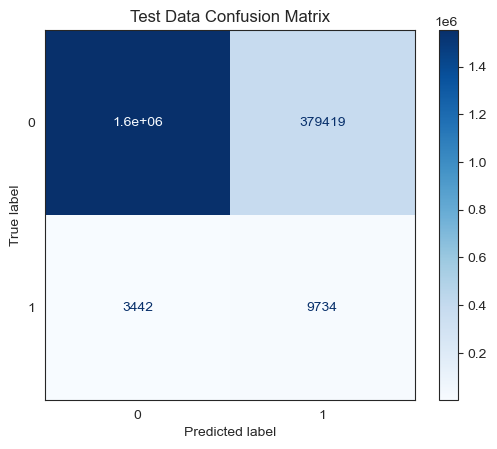

Test AUC-ROC: 0.85


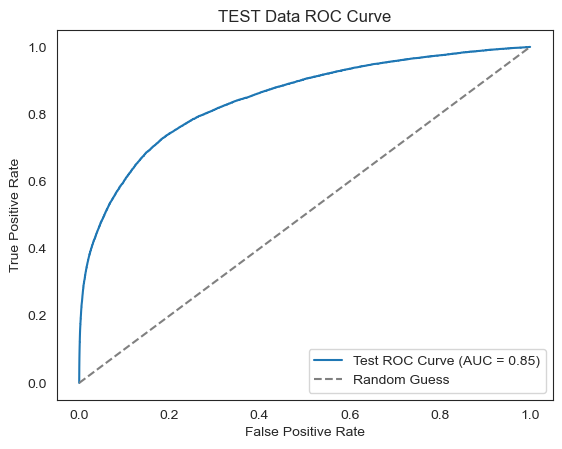

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

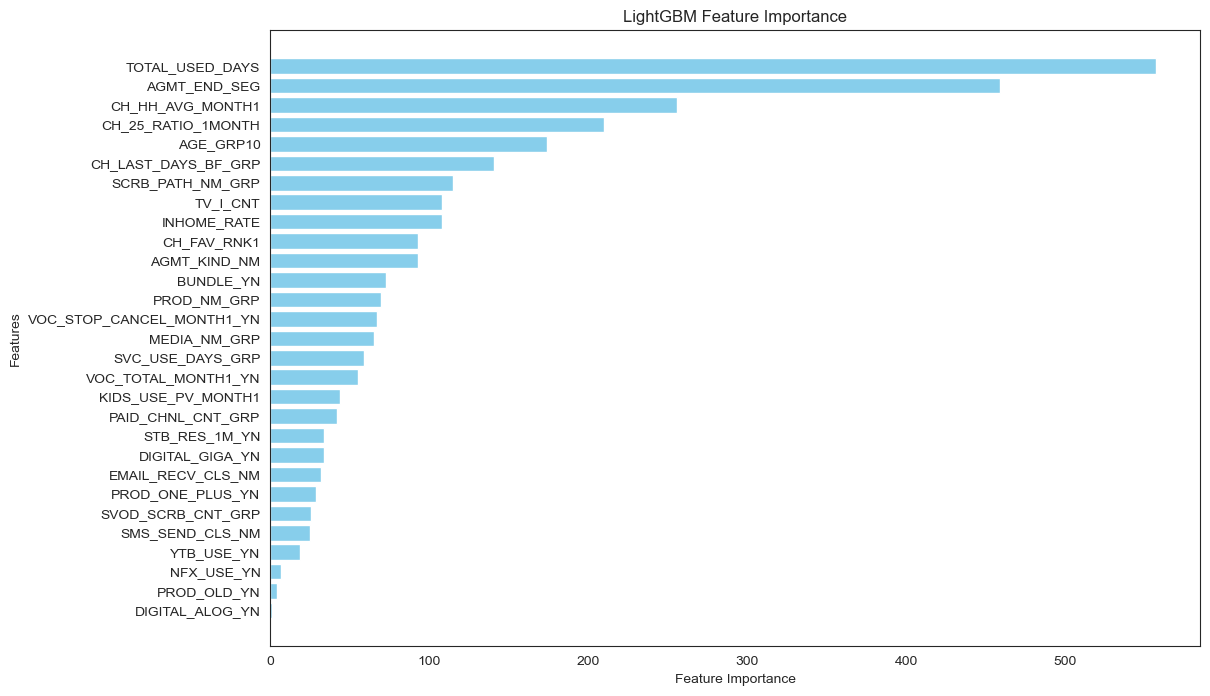

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 2. SMOTE-NC 데이터로 LGBM 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [19]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/smote_modeling/train.csv")
test = pd.read_csv("data/train/smote_modeling/test.csv")

LGBM 학습

In [20]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Test Accuracy: 0.86

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1932419
           1       0.02      0.49      0.05     13176

    accuracy                           0.86   1945595
   macro avg       0.51      0.68      0.49   1945595
weighted avg       0.99      0.86      0.92   1945595


Confusion Matrix (테스트 데이터):
[[1672222  260197]
 [   6773    6403]]


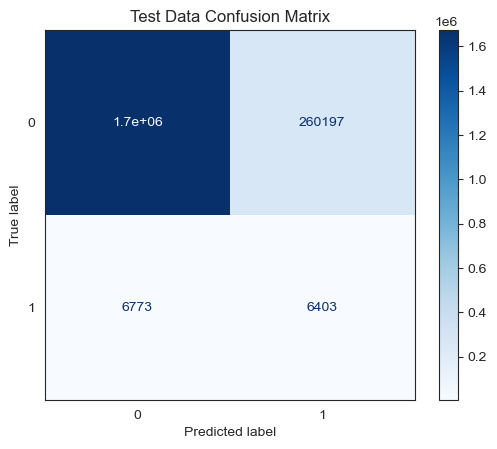

Test AUC-ROC: 0.75


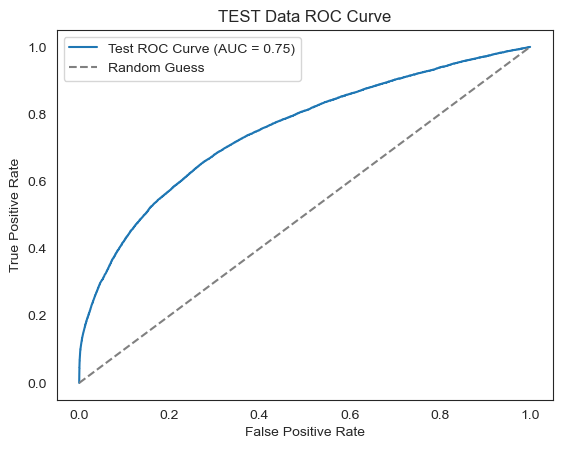

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

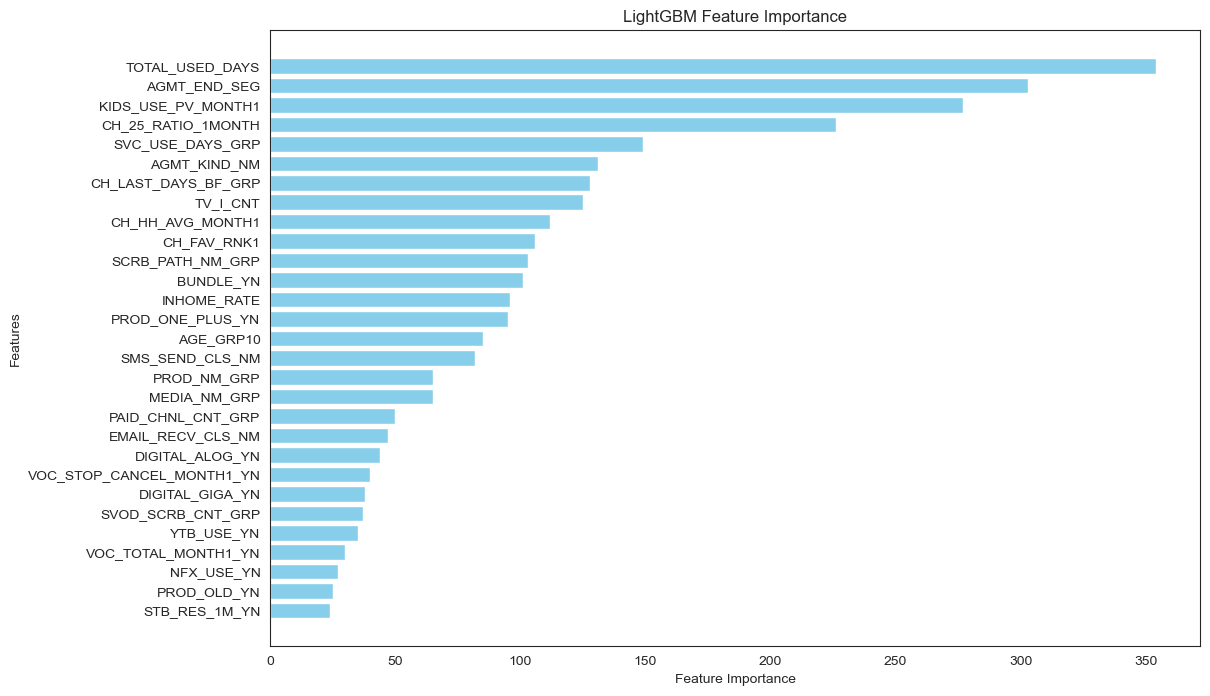

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 3. SMOTE-NC + 랜덤 언더 샘플링 데이터로 LGBM 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [24]:
# 레이블 인코딩, 정규화를 진행한 데이터 불러오기.

train = pd.read_csv("data/train/smoterandom_modeling/train.csv")
test = pd.read_csv("data/train/smoterandom_modeling/test.csv")

LGBM 학습

In [25]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

Test Accuracy: 0.86

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1932419
           1       0.02      0.49      0.05     13176

    accuracy                           0.86   1945595
   macro avg       0.51      0.68      0.49   1945595
weighted avg       0.99      0.86      0.92   1945595


Confusion Matrix (테스트 데이터):
[[1673532  258887]
 [   6766    6410]]


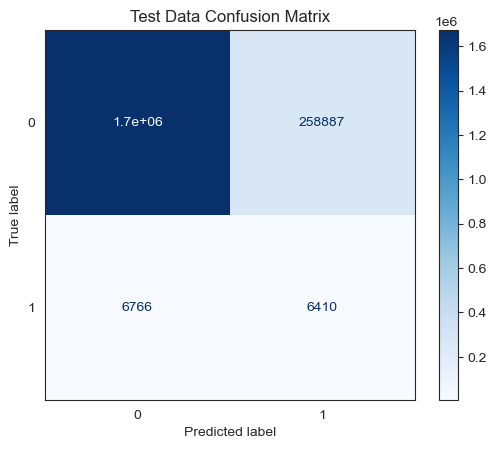

Test AUC-ROC: 0.75


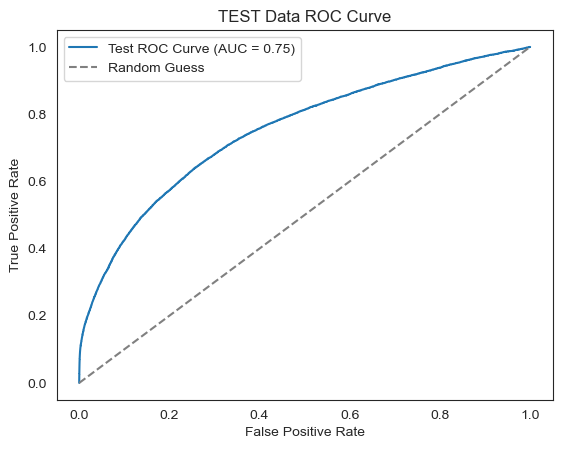

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

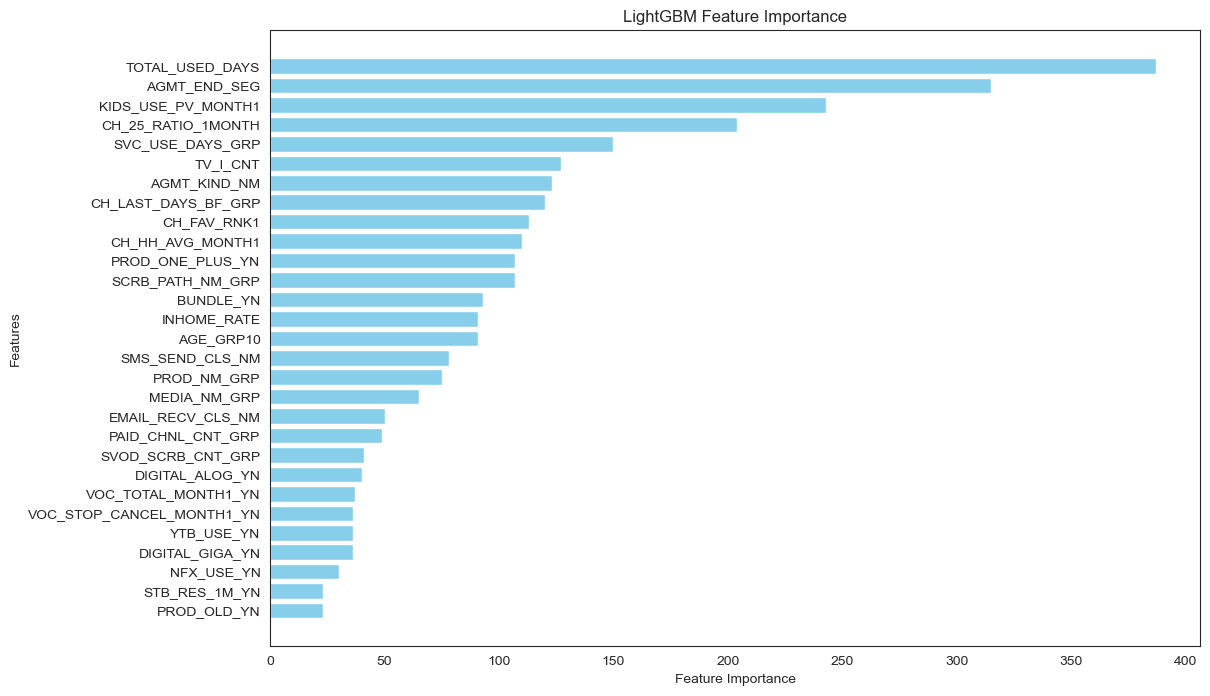

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

---

### 4. 가중치로 LGBM 진행

#### 레이블 인코딩 + 정규화 + 이상치가 있는 컬럼에는 Robust 스케일링 진행

In [29]:
train = pd.read_csv("data/train/train_weights.csv")
test = pd.read_csv("data/train/test.csv")

In [30]:
display(train)
display(test)

,sha2_hash,p_mt,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,4,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.00,약정만료전 9~12개월,20240325,794,Y,Y,N,3.00,3주일전,N,N,60대,수신,수신,9.86,기타,0.00,N,N,N,3.71
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,5,24개월~ 36개월미만,HD,이코노미,N,Y,신규,N,0건,0건,I/B,10.00,약정만료전 9~12개월,20240325,825,Y,Y,N,3.00,4주일전,N,N,60대,수신,수신,5.95,기타,0.00,N,N,N,3.57
2,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,4,12개월~24개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,30.00,약정만료전 12개월이상,20240616,4188,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,7.94,기타,0.00,N,N,N,0.12
3,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,5,12개월~24개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,50.00,약정만료전 12개월이상,20240616,4219,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,18.21,기타,0.00,N,N,N,0.02
4,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,4,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,일반상담,20.00,약정만료전 12개월이상,20250718,2427,Y,N,N,6.00,일주일내,Y,N,60대,수신,수신,1.39,기타,0.00,N,N,N,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914836,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,5,12개월~24개월미만,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,0.00,약정만료후 12개월이상,20141014,3775,N,N,N,2.00,일주일내,N,N,30대,전체거부,전체거부,0.85,기타,0.00,N,N,N,0.02
3914837,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,4,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20250614,1338,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,4.54,기타,1.00,N,N,N,0.51
3914838,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,5,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20250614,1369,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,5.79,기타,0.00,N,N,N,0.40
3914839,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,4,36개월 이상,HD,베이직,N,N,신규,N,0건,0건,현장경로,10.00,약정만료후 12개월이상,20200405,2215,N,N,N,1.00,일주일내,N,N,50대,수신,수신,2.42,KBS2,0.00,N,N,N,0.00


,sha2_hash,p_mt,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,AGMT_END_YMD,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,11,24개월~ 36개월미만,HD,이코노미,N,Y,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20260820,1008,Y,Y,N,3.00,일주일내,N,N,60대,수신,수신,6.23,기타,0.00,N,N,N,4.72
1,000015c9d6e36eac1e706b7495b536c36a7478897895f05e5b3b7f47a05fba34,11,24개월~ 36개월미만,HD,프리미엄,N,N,재약정,N,0건,0건,I/B,70.00,약정만료전 6~9개월,20240616,4402,Y,Y,N,2.00,일주일내,N,N,50대,수신,수신,15.37,기타,1.00,N,N,N,0.48
2,0000161608bc85042f2a7b2d51524e01e44da09a2c92ed7136f09c3b90414858,11,36개월 이상,HD,베이직,N,Y,재약정,N,0건,0건,일반상담,10.00,약정만료전 12개월이상,20250718,2641,Y,N,N,6.00,일주일내,N,N,60대,수신,수신,1.47,기타,1.00,N,N,N,2.97
3,00001c363e8c833646a913c7566acd329523316f6a03afc0fe77dac7ca828d17,11,36개월 이상,HD,이코노미,N,Y,신규,N,0건,0건,일반상담,10.00,약정만료후 9~12개월,20230127,1989,N,N,N,3.00,일주일내,N,N,60대,수신,수신,2.16,기타,0.00,N,N,N,11.85
4,00001f885d4d6c5ff6d01d5ebf1d6093d7f53c130de5fa3652dc0424d165b21c,11,36개월 이상,HD,프리미엄,N,Y,신규,N,1건,1건,현장경로,0.00,약정만료후 12개월이상,20190828,3979,Y,N,N,4.00,일주일내,Y,N,50대,수신,수신,1.64,기타,0.00,N,N,N,2.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945590,ffffdac172fec24c59aea00b7c6e53b8f9631e323cb99ada41a5fc7c38eaa74c,11,36개월 이상,HD,베이직,N,N,재약정,N,0건,0건,현장경로,0.00,약정만료후 12개월이상,20191114,3599,N,N,N,2.00,3개월내없음,N,N,50대,수신,수신,0.00,기타,0.00,N,N,N,0.00
1945591,ffffe2ae4b1bafe83133c187e7628932d4915bc7ee92457ac4b1b61e5362c3ba,11,36개월 이상,HD,이코노미,N,N,신규,N,1건,0건,O/B,10.00,약정만료후 12개월이상,20200831,2281,Y,N,N,3.00,일주일내,N,N,40대,전체거부,전체거부,1.81,MBN,0.00,N,N,N,4.40
1945592,ffffe9bc336450ed573a845cea2376c7dc913ba9d775e3223931ed33ba2f08f0,11,12개월~24개월미만,HD,이코노미,N,N,약정승계,N,0건,0건,일반상담,0.00,약정만료후 12개월이상,20141014,3958,N,N,N,2.00,일주일내,N,N,30대,수신,수신,1.69,기타,0.00,N,N,N,0.00
1945593,ffffeb35773f914285afa493a7b7cf236063af847c72f39cab28d078edfc74df,11,36개월 이상,UHD,베이직,N,N,재약정,N,0건,0건,I/B,20.00,약정만료전 12개월이상,20250614,1552,Y,N,N,2.00,일주일내,N,N,50대,수신,수신,3.39,기타,0.00,N,N,N,2.42


In [31]:
# INHOME_RATE 컬럼은 object로

train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)
print(train['INHOME_RATE'].dtypes)
print(test['INHOME_RATE'].dtypes)

object
object


In [32]:
train = train.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])
test = test.drop(columns=['sha2_hash','p_mt','AGMT_END_YMD'])

In [33]:
from sklearn.preprocessing import LabelEncoder

train_and_test = pd.concat([train, test])

categorical_cols = train_and_test.select_dtypes(include=['object']).columns

label_encoders = {}

for col in categorical_cols:
  le = LabelEncoder()
  train_and_test[col] = le.fit_transform(train_and_test[col])
  label_encoders[col] = le

# 인코딩 후, 다시 train과 test로 분리

train = train_and_test.iloc[:len(train)].reset_index(drop=True)
test = train_and_test.iloc[len(train):].reset_index(drop=True)

print("레이블 인코딩 끝! 😁")

레이블 인코딩 끝! 😁


In [34]:
for col, le in label_encoders.items():
    print(f"🔹 {col} 레이블 인코딩 매핑")
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(label_mapping)
    print("-" * 30)

🔹 SVC_USE_DAYS_GRP 레이블 인코딩 매핑
{'12개월~24개월미만': 0, '24개월~ 36개월미만': 1, '36개월 이상': 2, '6개월~12개월미만': 3, '6개월미만': 4}
------------------------------
🔹 MEDIA_NM_GRP 레이블 인코딩 매핑
{'HD': 0, 'UHD': 1, '기타': 2}
------------------------------
🔹 PROD_NM_GRP 레이블 인코딩 매핑
{'기타': 0, '베이직': 1, '세이버': 2, '스탠다드': 3, '이코노미': 4, '프리미엄': 5}
------------------------------
🔹 PROD_OLD_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 PROD_ONE_PLUS_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 AGMT_KIND_NM 레이블 인코딩 매핑
{'신규': 0, '약정갱신': 1, '약정승계': 2, '약정연장': 3, '약정축소': 4, '재약정': 5, '정보없음': 6}
------------------------------
🔹 STB_RES_1M_YN 레이블 인코딩 매핑
{'N': 0, 'Y': 1}
------------------------------
🔹 SVOD_SCRB_CNT_GRP 레이블 인코딩 매핑
{'0건': 0, '1건': 1, '2건': 2, '3건 이상': 3}
------------------------------
🔹 PAID_CHNL_CNT_GRP 레이블 인코딩 매핑
{'0건': 0, '1건': 1, '2건': 2, '3건 이상': 3}
------------------------------
🔹 SCRB_PATH_NM_GRP 레이블 인코딩 매핑
{'I/B': 0, 'O/B': 1, '기타': 2, '렌탈제휴': 3, '일반상담': 4, '임직원': 5,

In [35]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# boxplot으로 확인한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'KIDS_USE_PV_MONTH1', 'CH_25_RATIO_1MONTH']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [36]:
display(train, test)

,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,0.25,0.00,0.80,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.10,0.57,-1.37,1.00,1.00,0.00,0.40,0.40,0.00,0.00,0.56,0.67,0.67,1.08,0.92,0.00,0.00,0.00,0,0.87
1,0.25,0.00,0.80,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.10,0.57,-1.35,1.00,1.00,0.00,0.40,0.60,0.00,0.00,0.56,0.67,0.67,0.39,0.92,0.00,0.00,0.00,0,0.82
2,0.00,0.00,1.00,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.40,0.14,0.89,1.00,1.00,0.00,0.20,0.80,0.00,0.00,0.44,0.67,0.67,0.74,0.92,0.00,0.00,0.00,0,-0.28
3,0.00,0.00,1.00,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.60,0.14,0.91,1.00,1.00,0.00,0.20,0.80,0.00,0.00,0.44,0.67,0.67,2.54,0.92,0.00,0.00,0.00,0,-0.31
4,0.50,0.00,0.20,0.00,1.00,0.83,0.00,0.00,0.00,0.44,0.30,0.14,-0.28,1.00,0.00,0.00,1.00,0.80,1.00,0.00,0.56,0.67,0.67,-0.41,0.92,0.00,0.00,0.00,0,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914836,0.00,0.00,0.80,0.00,0.00,0.33,0.00,0.00,0.00,0.44,0.00,0.64,0.61,0.00,0.00,0.00,0.20,0.80,0.00,0.00,0.22,1.00,1.00,-0.50,0.92,0.00,0.00,0.00,0,-0.31
3914837,0.50,0.50,0.20,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.30,0.14,-1.01,1.00,0.00,0.00,0.20,0.80,0.00,0.00,0.44,0.67,0.67,0.14,0.92,1.00,0.00,0.00,0,-0.16
3914838,0.50,0.50,0.20,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.30,0.14,-0.99,1.00,0.00,0.00,0.20,0.80,0.00,0.00,0.44,0.67,0.67,0.36,0.92,0.00,0.00,0.00,0,-0.19
3914839,0.50,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.10,0.64,-0.42,0.00,0.00,0.00,0.00,0.80,0.00,0.00,0.44,0.67,0.67,-0.23,0.23,0.00,0.00,0.00,0,-0.32


,SVC_USE_DAYS_GRP,MEDIA_NM_GRP,PROD_NM_GRP,PROD_OLD_YN,PROD_ONE_PLUS_YN,AGMT_KIND_NM,STB_RES_1M_YN,SVOD_SCRB_CNT_GRP,PAID_CHNL_CNT_GRP,SCRB_PATH_NM_GRP,INHOME_RATE,AGMT_END_SEG,TOTAL_USED_DAYS,BUNDLE_YN,DIGITAL_GIGA_YN,DIGITAL_ALOG_YN,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_TOTAL_MONTH1_YN,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,EMAIL_RECV_CLS_NM,SMS_SEND_CLS_NM,CH_HH_AVG_MONTH1,CH_FAV_RNK1,KIDS_USE_PV_MONTH1,NFX_USE_YN,YTB_USE_YN,churn,CH_25_RATIO_1MONTH
0,0.25,0.00,0.80,0.00,1.00,0.83,0.00,0.00,0.00,0.00,0.30,0.14,-1.23,1.00,1.00,0.00,0.40,0.80,0.00,0.00,0.56,0.67,0.67,0.44,0.92,0.00,0.00,0.00,0,1.19
1,0.25,0.00,1.00,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.80,0.50,1.03,1.00,1.00,0.00,0.20,0.80,0.00,0.00,0.44,0.67,0.67,2.04,0.92,1.00,0.00,0.00,0,-0.17
2,0.50,0.00,0.20,0.00,1.00,0.83,0.00,0.00,0.00,0.44,0.10,0.14,-0.14,1.00,0.00,0.00,1.00,0.80,0.00,0.00,0.56,0.67,0.67,-0.39,0.92,1.00,0.00,0.00,0,0.63
3,0.50,0.00,0.80,0.00,1.00,0.00,0.00,0.00,0.00,0.44,0.10,1.00,-0.57,0.00,0.00,0.00,0.40,0.80,0.00,0.00,0.56,0.67,0.67,-0.27,0.92,0.00,0.00,0.00,0,3.47
4,0.50,0.00,1.00,0.00,1.00,0.00,0.00,0.33,0.33,1.00,0.00,0.64,0.75,1.00,0.00,0.00,0.60,0.80,1.00,0.00,0.44,0.67,0.67,-0.36,0.92,0.00,0.00,0.00,0,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945590,0.50,0.00,0.20,0.00,0.00,0.83,0.00,0.00,0.00,1.00,0.00,0.64,0.50,0.00,0.00,0.00,0.20,0.20,0.00,0.00,0.44,0.67,0.67,-0.65,0.92,0.00,0.00,0.00,0,-0.32
1945591,0.50,0.00,0.80,0.00,0.00,0.00,0.00,0.33,0.00,0.11,0.10,0.64,-0.38,1.00,0.00,0.00,0.40,0.80,0.00,0.00,0.33,1.00,1.00,-0.33,0.38,0.00,0.00,0.00,0,1.09
1945592,0.00,0.00,0.80,0.00,0.00,0.33,0.00,0.00,0.00,0.44,0.00,0.64,0.74,0.00,0.00,0.00,0.20,0.80,0.00,0.00,0.22,0.67,0.67,-0.36,0.92,0.00,0.00,0.00,0,-0.32
1945593,0.50,0.50,0.20,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.30,0.14,-0.86,1.00,0.00,0.00,0.20,0.80,0.00,0.00,0.44,0.67,0.67,-0.06,0.92,0.00,0.00,0.00,0,0.45


LGBM 학습

In [37]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    class_weight='balanced',  # 클래스 가중치 적용
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

Test Accuracy: 0.81

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1932419
           1       0.03      0.73      0.05     13176

    accuracy                           0.81   1945595
   macro avg       0.51      0.77      0.47   1945595
weighted avg       0.99      0.81      0.89   1945595


Confusion Matrix (테스트 데이터):
[[1567023  365396]
 [   3542    9634]]


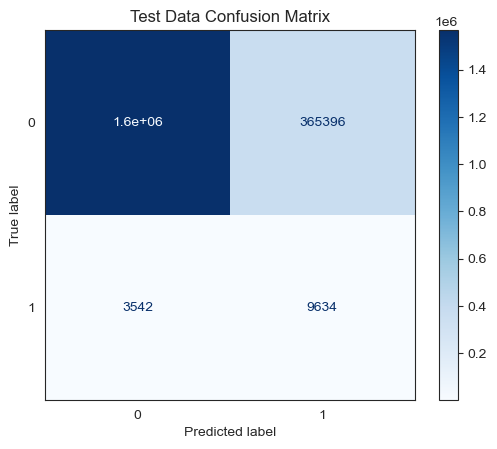

Test AUC-ROC: 0.85


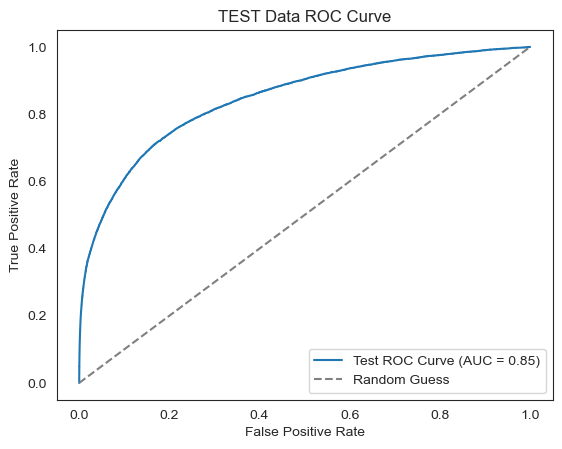

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

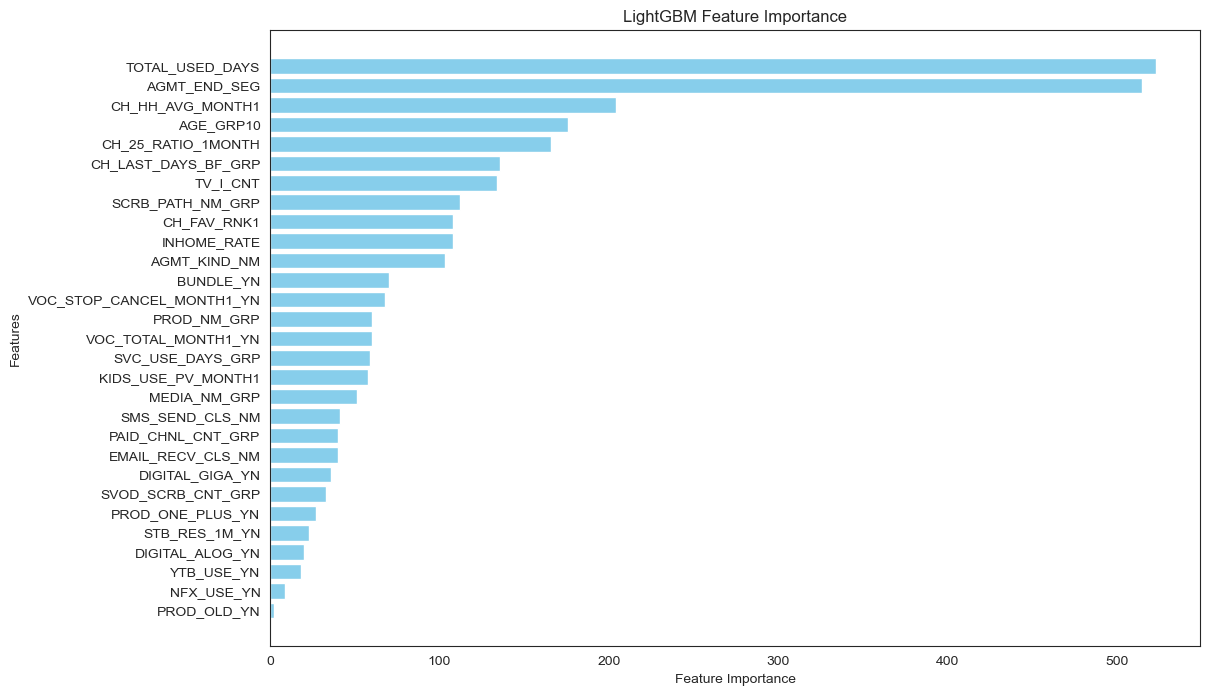

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

#### 결론
LGBM는 랜덤 언더, 가중치를 했을 때, 가장 좋다

### 📌 LGBM 성능 비교 (Sampling 기법별)

| 샘플링 기법             | Accuracy | 1의 Recall | ROC-AUC |
|------------------------|----------|-----------|---------|
| <span style="color:red;">**랜덤 언더샘플링**</span>     | 0.80     | 0.74      | 0.85    |
| **SMOTE**              | 0.86     | 0.49      | 0.75    |
| **SMOTE + 랜덤 언더샘플링** | 0.86     | 0.48      | 0.74    |
| <span style="color:red;">**가중치 조정**</span>        | 0.81     | 0.73      | 0.85    |